In [3]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, r_regression, SelectFromModel, f_regression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.svm import SVR
from matplotlib.colors import Normalize
from matplotlib import rcParams
from sklearn.impute import SimpleImputer

# Pre-processing

In [44]:
database_fuel = pd.read_csv("DATA/influxdata_fuel_08_05.csv", header =3)
database_electrical = pd.read_csv("DATA/influxdata_electricity_22_04.csv", header= 3)
database_fuel_old = pd.read_csv("DATA/February_machine_data.csv")
database_fuel_old = database_fuel_old[database_fuel_old['fuel_consumption'] > 0].dropna()
database_electrical.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
devices = {860751070815789: ["Crane 1",0.08],
           860751070821126: ["Crane 2",0.07],
           860751070821241: ["Mobile Crane",0.012],
           860751070821829: ["Box #5.5",0.01],
          860751076088647: ["Outdoor Lighting #5.5",0.002]}
database_electrical = database_electrical[database_electrical["sensor"].isin(devices.keys())]
database_electrical = database_electrical[database_electrical['value'] > 0.0].copy()
database_electrical["device"] = database_electrical["sensor"].map(lambda x: devices[x][0] if x in devices else "other")
database_electrical["threshold"] = database_electrical["sensor"].map(lambda x: devices[x][1] if x in devices else 0)
database_electrical["source"] = "electricity"
database_electrical["incremental_value"] = database_electrical["value"] 
database_electrical.sort_values(by=["sensor","time"], inplace=True) 
database_electrical['value'] = (database_electrical.groupby('sensor')['incremental_value'].diff().fillna(0).round(5))
database_electrical["CO2"] = round(database_electrical["value"] * 0.173, 5)
database_electrical['time'] = pd.to_datetime(database_electrical['time'])
database_electrical['date'] = database_electrical["time"].dt.strftime('%Y-%m-%d')
database_electrical = database_electrical.groupby(['time', 'device', "sensor", "value", "incremental_value", "threshold", "date"], as_index=False)['CO2'].sum()
database_electrical.sort_values(by=["sensor","time"], inplace=True) 
database_electrical["status"] = database_electrical.apply(lambda row: "working" if row["value"] >= row["threshold"] else "idle", axis=1) 

NameError: name 'database_electrical' is not defined

In [46]:
database_electrical

,time,device,sensor,value,incremental_value,threshold,CO2,status
2,2025-04-02 07:29:47+00:00,Crane 1,860751070815789,0.00,56.89,0.08,0.00000,idle
7,2025-04-02 07:39:47+00:00,Crane 1,860751070815789,0.11,57.00,0.08,0.01903,working
13,2025-04-02 07:49:48+00:00,Crane 1,860751070815789,0.08,57.08,0.08,0.01384,working
18,2025-04-02 07:59:48+00:00,Crane 1,860751070815789,0.07,57.15,0.08,0.01211,idle
23,2025-04-02 08:09:48+00:00,Crane 1,860751070815789,0.06,57.21,0.08,0.01038,idle
...,...,...,...,...,...,...,...,...
25994,2025-04-22 08:10:17+00:00,other,861275070732868,0.01,2.39,0.00,0.00173,working
25996,2025-04-22 08:11:17+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working
25998,2025-04-22 08:12:17+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working
26000,2025-04-22 08:13:18+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working


In [47]:
database_fuel = database_fuel[database_fuel['fuel_count'] > 0]
database_fuel.sort_values(by=["time"], inplace=True) 
database_fuel["timestamp"] =  [database_fuel.iloc[i]["time"][:16] for i in range(len(database_fuel))] 
database_fuel["CODE"] = [database_fuel.iloc[i]["machine"][:5] for i in range(len(database_fuel))] 
database_fuel = database_fuel.groupby(["machine", "timestamp"], as_index=False).first()
database_fuel["fuel_consumption"] = [0]+[database_fuel.iloc[i]["fuel_count"]-database_fuel.iloc[i-1]["fuel_count"] for i in range(1,len(database_fuel))]
database_fuel["engine_hours"] = [0]+[database_fuel.iloc[i]["engine_hours_cnt"]-database_fuel.iloc[i-1]["engine_hours_cnt"] for i in range(1,len(database_fuel))]
database_fuel["status"] = ["working" if database_fuel.iloc[i]["engine_load"]>=0.4 else "idle" if database_fuel.iloc[i]["engine_load"]>=0.1 else "down"
                           for i in range(len(database_fuel))]
database_fuel["distance"] = [0]+[database_fuel.iloc[i]["distance"]-database_fuel.iloc[i-1]["distance"] for i in range(1,len(database_fuel))]
database_fuel.drop(columns=["Unnamed: 0", "distance_tot", "driving_hours", "speed", "engine_hours_tot",  "time",
                            "engine_hours_cnt","fuel_tot", "idle_time", "RPM", "mileage", "fuel_level"], inplace=True)
database_fuel["timestamp"] = pd.to_datetime(database_fuel["timestamp"])
database_fuel["hour"] = pd.DatetimeIndex(database_fuel['timestamp']).hour
database_fuel["source"] = "fuel"

In [48]:
database_fuel_old = database_fuel_old.rename(columns={"engine_voltage": "Voltage", "engine_temperature":"Temperature"})
database_fuel_old.drop(columns=["idle_time", "mileage"], inplace=True)
database_fuel_old["timestamp"] = (pd.to_datetime(database_fuel_old.timestamp, format="%d-%m-%Y %H:%M")).dt.strftime('%Y-%m-%d %H:%M:%S')
database_fuel = pd.concat([database_fuel, database_fuel_old])
database_fuel["CO2"] = round(database_fuel["fuel_consumption"] * 2.667, 5)

In [49]:
database_fuel_old

,machine,timestamp,engine_hours,fuel_consumption,CODE,RPM,engine_load,idle_threshold,hour,status,source,Voltage,Temperature
723,Caterpillar_323F,2025-02-10 14:31:00,3.42,66.2,323F,1000.0,0.0,950.0,14.0,working,fuel,28200.0,56.0
724,Caterpillar_323F,2025-02-10 14:32:00,3.43,66.6,323F,1001.0,0.0,950.0,14.0,working,fuel,28200.0,57.0
725,Caterpillar_323F,2025-02-10 14:33:00,3.43,67.0,323F,996.0,0.0,950.0,14.0,working,fuel,28200.0,58.0
726,Caterpillar_323F,2025-02-10 14:34:00,3.45,67.4,323F,998.0,0.0,950.0,14.0,working,fuel,28200.0,59.0
727,Caterpillar_323F,2025-02-10 14:35:00,3.48,68.1,323F,1001.0,0.0,950.0,14.0,working,fuel,28300.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Caterpillar_938M,2025-02-13 14:45:00,2.33,24.5,938M,1566.0,0.0,850.0,14.0,working,fuel,27400.0,71.0
5356,Caterpillar_938M,2025-02-13 14:46:00,2.33,24.5,938M,1219.0,0.0,850.0,14.0,working,fuel,27400.0,69.0
5357,Caterpillar_938M,2025-02-13 14:47:00,2.33,24.5,938M,0.0,0.0,850.0,14.0,down,fuel,25600.0,68.0
5358,Caterpillar_938M,2025-02-13 14:48:00,2.33,24.5,938M,1228.0,0.0,850.0,14.0,working,fuel,27400.0,68.0


In [50]:
database_clean = database_fuel
num_cols = database_fuel.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')      # Create an imputer with a missing indicator to handle numerical features only present in one of the 2
database_clean[num_cols] = imputer.fit_transform(database_clean[num_cols])

In [51]:
database_fuel

,machine,timestamp,Temperature,Voltage,distance,engine_hours,engine_load,fuel_consumption,fuel_count,lat,lon,CODE,status,hour,source,RPM,idle_threshold,CO2
0,13013-MerloP40.17,2025-04-08 09:43:00,620.0,13217.0,0.000000,0.00,38.0,0.0,22981.000000,55.720757,9.127180,13013,working,9.0,fuel,1317.577612,872.835821,0.0000
1,13013-MerloP40.17,2025-04-08 09:44:00,740.0,13233.0,532.000000,1.00,38.0,1.0,22982.000000,55.721920,9.127849,13013,working,9.0,fuel,1317.577612,872.835821,2.6670
2,13013-MerloP40.17,2025-04-08 09:45:00,810.0,13259.0,111.000000,1.00,11.0,0.0,22982.000000,55.721940,9.128573,13013,working,9.0,fuel,1317.577612,872.835821,0.0000
3,13013-MerloP40.17,2025-04-08 09:46:00,770.0,13134.0,20.000000,1.00,0.0,1.0,22983.000000,55.721770,9.128741,13013,down,9.0,fuel,1317.577612,872.835821,2.6670
4,13013-MerloP40.17,2025-04-08 09:47:00,820.0,13246.0,178.000000,1.00,36.0,0.0,22983.000000,55.721043,9.127085,13013,working,9.0,fuel,1317.577612,872.835821,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Caterpillar_938M,2025-02-13 14:45:00,71.0,27400.0,37.577765,2.33,0.0,24.5,23445.063868,55.721112,9.127759,938M,working,14.0,fuel,1566.000000,850.000000,65.3415
5356,Caterpillar_938M,2025-02-13 14:46:00,69.0,27400.0,37.577765,2.33,0.0,24.5,23445.063868,55.721112,9.127759,938M,working,14.0,fuel,1219.000000,850.000000,65.3415
5357,Caterpillar_938M,2025-02-13 14:47:00,68.0,25600.0,37.577765,2.33,0.0,24.5,23445.063868,55.721112,9.127759,938M,down,14.0,fuel,0.000000,850.000000,65.3415
5358,Caterpillar_938M,2025-02-13 14:48:00,68.0,27400.0,37.577765,2.33,0.0,24.5,23445.063868,55.721112,9.127759,938M,working,14.0,fuel,1228.000000,850.000000,65.3415


In [52]:
database_electrical.to_csv("electrical_data.csv", index=False)
database_fuel.to_csv("fuel_data.csv", index=False)

## Transparency:
(Only useful for dark presentations)

In [53]:
#rcParams['text.color'] = 'white'
#rcParams['axes.labelcolor'] = 'white'
#rcParams['xtick.color'] = 'white'
#rcParams['ytick.color'] = 'white'
#rcParams['axes.edgecolor'] = 'white'

# Key Performance Indicators

In [25]:
J = list(database_electrical.device.unique())
for i in J:
    print(i)


Crane 1
Crane 2
Mobile Crane
Box #5.5
Outdoor Lighting #5.5
other


In [ ]:
database_electrical[database_electrical["device"]=="Crane 1"].iloc[-1]["incremental_value"]

276.49

In [75]:
database_electrical

,time,device,sensor,value,incremental_value,threshold,CO2,status
2,2025-04-02 07:29:47+00:00,Crane 1,860751070815789,0.00,56.89,0.08,0.00000,idle
7,2025-04-02 07:39:47+00:00,Crane 1,860751070815789,0.11,57.00,0.08,0.01903,working
13,2025-04-02 07:49:48+00:00,Crane 1,860751070815789,0.08,57.08,0.08,0.01384,working
18,2025-04-02 07:59:48+00:00,Crane 1,860751070815789,0.07,57.15,0.08,0.01211,idle
23,2025-04-02 08:09:48+00:00,Crane 1,860751070815789,0.06,57.21,0.08,0.01038,idle
...,...,...,...,...,...,...,...,...
25994,2025-04-22 08:10:17+00:00,other,861275070732868,0.01,2.39,0.00,0.00173,working
25996,2025-04-22 08:11:17+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working
25998,2025-04-22 08:12:17+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working
26000,2025-04-22 08:13:18+00:00,other,861275070732868,0.00,2.39,0.00,0.00000,working


In [78]:
database_electrical["time"].astype(str).str[:10]

2        2025-04-02
7        2025-04-02
13       2025-04-02
18       2025-04-02
23       2025-04-02
            ...    
25994    2025-04-22
25996    2025-04-22
25998    2025-04-22
26000    2025-04-22
26001    2025-04-22
Name: time, Length: 26004, dtype: object

### Total kWh by interval / daily


In [ ]:
def interval_emission(data, start, end):
    database = data[(data["time"]>= start) & (data["time"]<= end)]
    total_kWh = 0
    # INtegrate CO2 emission factors fluctuations on a later day.
    for i in list(database.device.unique()):
        total_kWh += database[database["device"]=="Crane 1"].iloc[-1]["incremental_value"] - database[database["device"]=="Crane 1"].iloc[0]["incremental_value"]
    CO2 = total_kWh * 0.173
    return CO2


def daily_emission(data, day, machine=None):
    database = data[data["time"].astype(str).str[:10] == "2025-04-08"]
    if machine is not None:
        database = database[database["device"]==machine]
    total_kWh = 0
    # INtegrate CO2 emission factors fluctuations on a later day.
    for i in list(database.device.unique()):
        total_kWh += database[database["device"]=="Crane 1"].iloc[-1]["incremental_value"] - database[database["device"]=="Crane 1"].iloc[0]["incremental_value"]
    CO2 = total_kWh * 0.173
    return CO2

In [89]:
daily_emission(database_electrical, "2025-04-10")

7.525499999999999

In [60]:
database = database_electrical[database_electrical["time"].astype(str).str[:9] == "2025-04-08"]
database

,time,device,sensor,value,incremental_value,threshold,CO2,status


### Electricity by surface

In [44]:
def surface(CO2, surface= 160000):
    Ratio = CO2 / surface
    return surface

In [ ]:
def local_consumption(total_CO2, site):
    local_CO2 = total_CO2[site]
    return local_CO2

### Working/Idle classification

In [ ]:
database_electrical["C02"]

,time,device,sensor,CO2
0,2025-04-02 07:21:47+00:00,Outdoor Lighting #5.5,860751076088647,1.29058
1,2025-04-02 07:23:36+00:00,Box #5.5,860751070821829,1.74038
2,2025-04-02 07:29:47+00:00,Crane 1,860751070815789,9.84197
3,2025-04-02 07:30:47+00:00,other,861275070732868,0.16608
4,2025-04-02 07:31:47+00:00,Outdoor Lighting #5.5,860751076088647,1.29058
...,...,...,...,...
25999,2025-04-22 08:13:00+00:00,Crane 1,860751070815789,47.83277
26000,2025-04-22 08:13:18+00:00,other,861275070732868,0.41347
26001,2025-04-22 08:14:18+00:00,other,861275070732868,0.41347
26002,2025-04-22 08:15:03+00:00,Mobile Crane,860751070821241,6.52729


# Data Analysis

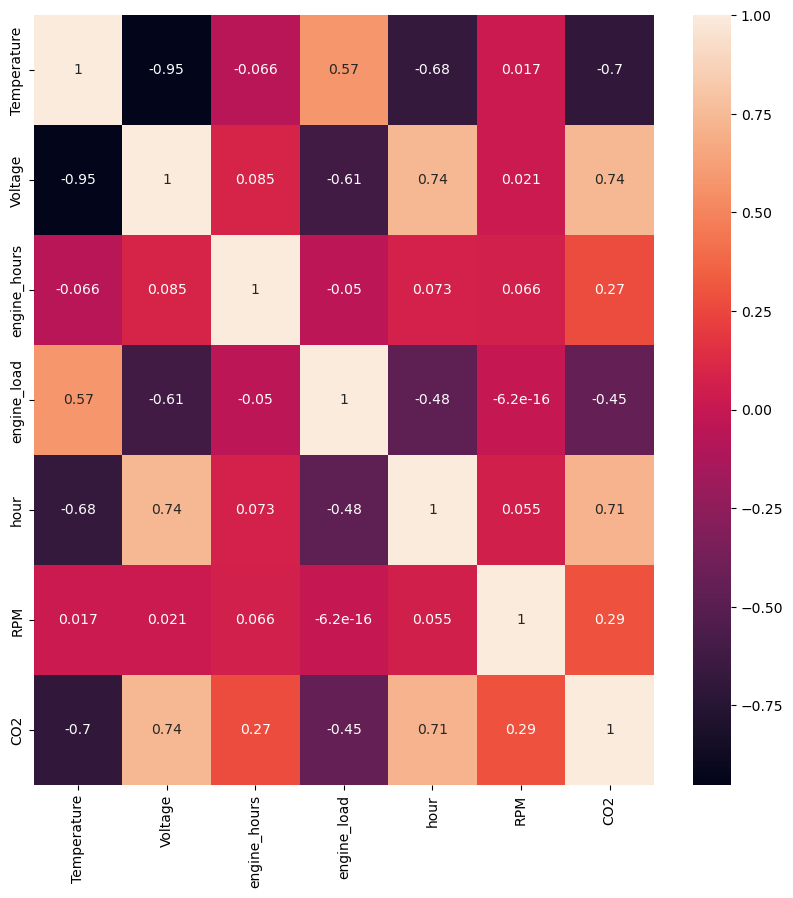

In [11]:
database_clean = database_clean.drop(columns=["source", "machine", "CODE", "timestamp", "status", "idle_threshold",
                                              "fuel_count", "lat", "lon","distance"], axis =1)       #engine_load could also be excluded tbh.
database_clean_X = database_clean.drop(columns=["fuel_consumption"], axis =1)       #engine_load could also be excluded tbh.
plt.figure(figsize = (10, 10), )
sns.heatmap(database_clean_X.corr(), annot = True)
plt.savefig("Charts/covariance matrix.png", transparent= True)


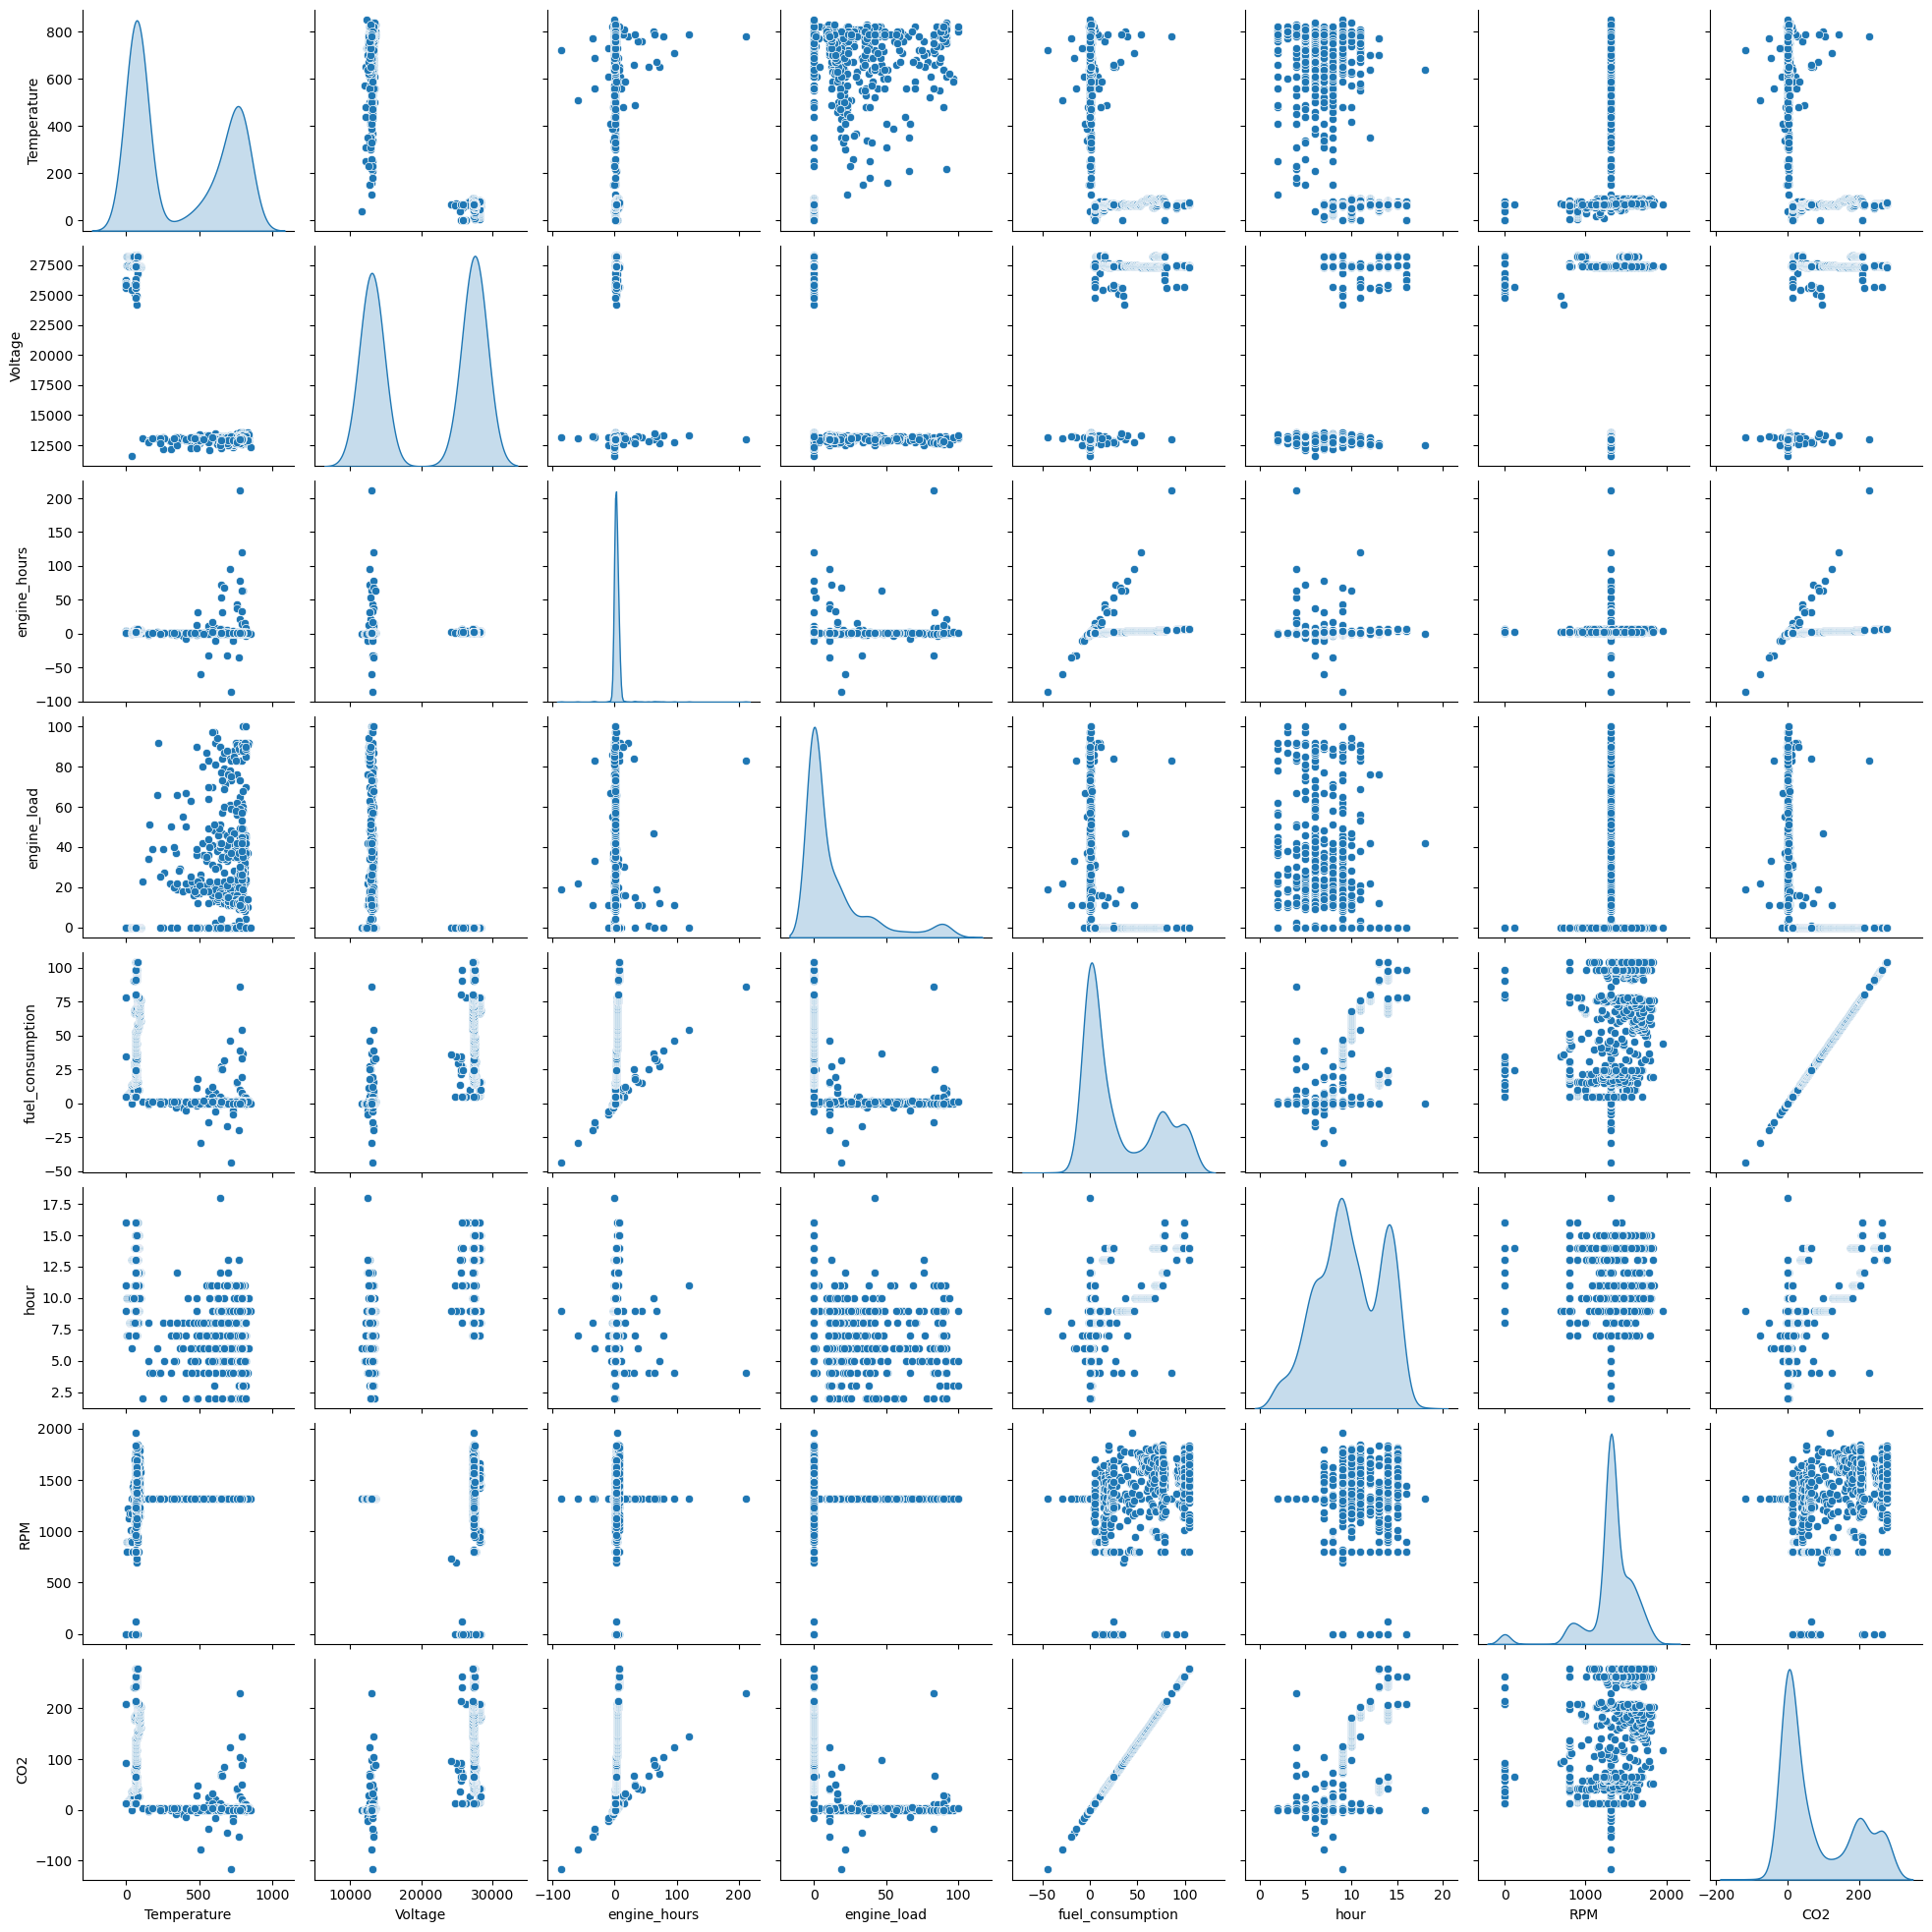

In [12]:
sns.pairplot(database_clean, diag_kind="kde")
plt.savefig("Charts/pairplot.png", transparent= True)


In [13]:
database_clean = database_clean.dropna()

In [14]:
y = database_clean["fuel_consumption"] 
X = database_clean_X                    #CO2 is always proportional to fuel consumption. Removed all string columns.

## Univariate feature selection
Before moving on I decide to only keep the most relevant factors for our regression task. Three are the approaches that can be taken:
- assigning weights to each feature according to their importance (optimistic approach).
- r_regression only selects the *k* features with highest Pearson's correlation coefficient.
- f_regression only selects the *k* features with highest F-statistics and p-values.

Alternative: **recursion feature selection**. Given an external estimator that assigns weights to features (e.g., the coefficients of a chosen model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [15]:
# Applying SelectKBest with ANOVA F-value
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

# Displaying scores for each feature
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print(feature_scores.sort_values(by='Score', ascending=False))

# column index of top-k features
cols = np.sort(selector.scores_.argsort()[-6:])
cols
# index the top-k features from X
X_selected = X.iloc[:, cols]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25) 

        Feature         Score
6           CO2  1.839212e+17
1       Voltage  1.531726e+03
4          hour  1.321300e+03
0   Temperature  1.204228e+03
3   engine_load  3.182757e+02
5           RPM  1.193727e+02
2  engine_hours  1.025372e+02


## Algorithm Selection

### Linear Regression 

In [16]:
#R method
databaselm = database_fuel
lm = ols('fuel_consumption ~ engine_load + fuel_consumption + Voltage + distance + engine_hours +status', data=databaselm)
fitted_model = lm.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       fuel_consumption   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.439e+28
Date:                Tue, 22 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:40:24   Log-Likelihood:                 32365.
No. Observations:                1268   AIC:                        -6.471e+04
Df Residuals:                    1260   BIC:                        -6.467e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.958e-13   2.89e-13     -1.024      0.306   -8.63e-13    2.71e-13
status[T.idle]     1.601e-13   3.08e-13      0.519      0.604   -4.45e-13    7.65e-13
status[T.working] -1.202e-13    2.1e-13     -0.572      0.567   -5.32e-13    2.92e-13
engine_load        3.784e-15   3.31e-15      1.144      0.253    -2.7e-15    1.03e-14
fuel_consumption      1.0000   2.64e-15   3.79e+14      0.000       1.000       1.000
Voltage           -8.516e-17   1.48e-17     -5.749      0.000   -1.14e-16   -5.61e-17
distance           1.385e-15   4.57e-16      3.029      0.002    4.88e-16    2.28e-15
engine_hours       2.095e-15   1.79e-14      0.117      0.907    -3.3e-14    3.72e-14
==============================================================================
Omnibus:                      997.364   Durbin-Watson:                   0.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69915.171
Skew:                          -3.065   Prob(JB):                         0.00
Kurtosis:                      38.857   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
lm = LinearRegression().fit(X_train, y_train)
predictions = lm.predict(X_test) 
# model evaluation 
print('Linear Regression test root mean squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('Linear Regression test mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(lm.score(X_test, y_test)*100, 2), "%")

Linear Regression test root mean squared error: 8.894324665356966e-14
Linear Regression test mean absolute error: 7.842006004139311e-14
R squared test set 100.0 %


Logistic Regression cannot be used as it is not a classification task.

In [18]:
#log = LogisticRegression().fit(X_train, y_train)
#predictions = log.predict(X_test) 
## model evaluation 
#print('Logistic Regressionroot_mean_squared error: ', mean_squared_error(y_test, predictions)) 
#print('Logistic Regression test mean absolute error:: ', mean_absolute_error(y_test, predictions)) 

### Lasso/Ridge Regression

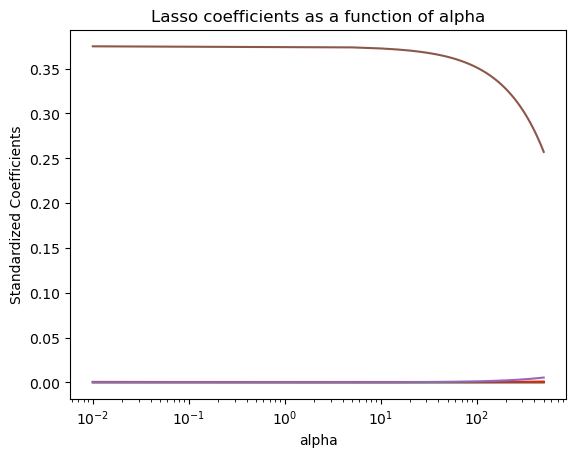

In [19]:
alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.savefig("Charts/Lasso coefficients.png", transparent= True)
plt.show()

In [20]:
columns = X_selected.columns
X_train_std = X_train
X_test_std = X_test

#Rescaling for Lasso / Ridge regression
scaler = StandardScaler().fit(X_train[columns])
X_train_std[columns] = scaler.transform(X_train[columns])
X_test_std[columns] = scaler.transform(X_test[columns])

model = LassoCV(cv=5, max_iter=1000).fit(X_train_std, y_train)
model.alpha_

0.037164098745269804

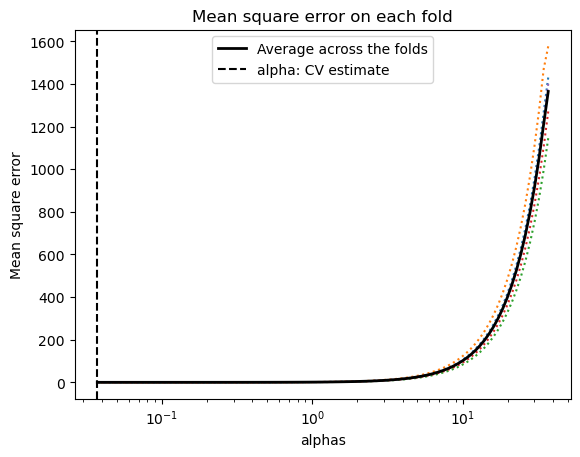

In [21]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")
#plt.ylim(0, 150)
#plt.xlim(0.02,10)
plt.savefig("Charts/Alpha values.png", transparent= True)
plt.show()


In [22]:
#Find the best lambda!!!

lasso =  Lasso(alpha=model.alpha_).fit(X_train_std, y_train)
predictions = lasso.predict(X_test_std) 

# model evaluation 
print('Lasso Regression test root mean squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('Lasso Regression test mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(lasso.score(X_test, y_test)*100, 2), "%")

model_l = SelectFromModel(lasso, prefit=True)
# Displaying selected features
selected_features = pd.DataFrame({'Feature': X_selected.columns, 'Selected': model_l.get_support()})
print(selected_features[selected_features['Selected'] == True])

ridge =  Ridge(alpha=model.alpha_).fit(X_train_std, y_train)
predictions = ridge.predict(X_test_std) 

# model evaluation 
print('Ridge Regression test root mean squared error:', np.sqrt(mean_squared_error(y_test, predictions)))
print('Ridge Regression test mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(ridge.score(X_test, y_test)*100, 2), "%")

Lasso Regression test root mean squared error: 0.03900987989136782
Lasso Regression test mean absolute error: 0.03504595527873928
R squared test set 100.0 %
  Feature  Selected
5     CO2      True
Ridge Regression test root mean squared error: 0.002407639156913328
Ridge Regression test mean absolute error: 0.0017932209154815407
R squared test set 100.0 %


Based on this results Lasso regression is less accurate, meaning that excluding parameters undermines the predictive power of the model.

This is due to the fact that we have very limited data and the variables are not shown the full extent of values they can have for different circumstances (idle, working, different types of machines).

### K-Nearest Neighbours Regression

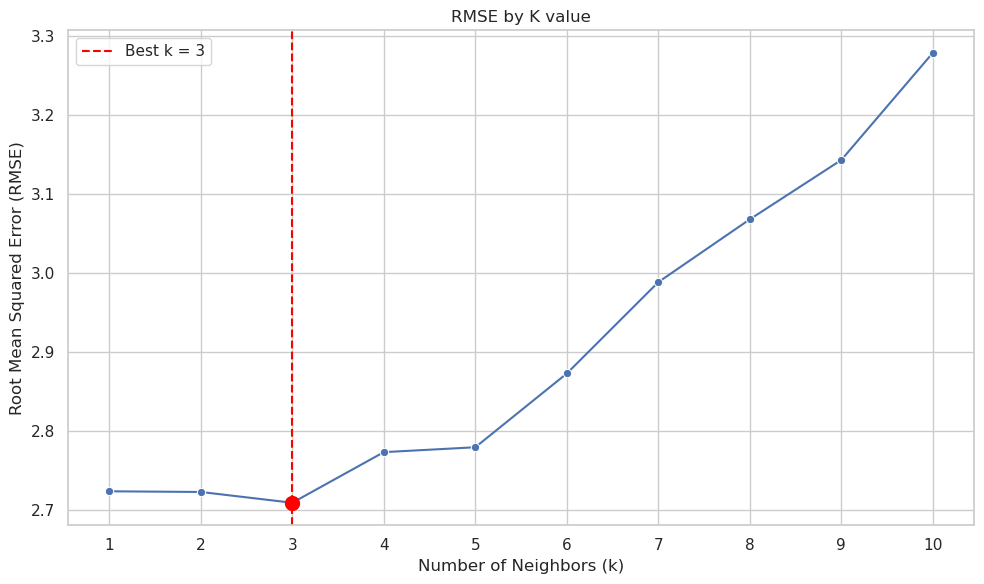

In [23]:
k=10
error_array=np.zeros(k)
for k in np.arange(1,k+1,1): # here k will take values from 1 to 10
    reg = KNeighborsRegressor(n_neighbors=k).fit(X_train,y_train) # k changes after each iteration
    y_pred = reg.predict(X_test)
    error = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    error_array[k-1]=error # store correctly the results
min_err = np.amin(error_array)              #we want to minimize RMSE
err_list = list(error_array)
k = (err_list.index(min_err))+1           #find the best k value!!

k_values = np.arange(1,11)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=error_array, marker='o')
plt.title('RMSE by K value')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.xticks(k_values)
plt.axvline(x=k, linestyle='--', color='red', label=f'Best k = {k}')
plt.scatter(k, min_err, color='red', s=100, zorder=5)
plt.legend()
plt.tight_layout()
plt.savefig("Charts/silhouette score by k.png", transparent= True)

plt.show()


In [24]:
##Find best k.
#fit the model.
knn_regressor = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)

predictions = knn_regressor.predict(X_test) 
print('KNN Regression test root mean squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('KNN Regression test mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R-squared test set ', round(knn_regressor.score(X_test, y_test)*100, 2), "%")

KNN Regression test root mean squared error: 2.7091968614461
KNN Regression test mean absolute error: 1.1213459516298638
R-squared test set  99.52 %


### Support Vector Regression

In [30]:
#%% script false
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25)

# Cross validation grid search (best parameters) 
c_range = [1, 10, 100, 1000]
gamma_range = [0.00001, 0.0001, 0.001, 0.01]
tuned_parameters = [{'svr__kernel': ['rbf', "linear"],'svr__C': c_range,'svr__gamma':gamma_range}]
svr = make_pipeline(StandardScaler(), SVR())
clf = GridSearchCV(svr,param_grid=tuned_parameters,verbose=20,n_jobs=1,cv=4, scoring='explained_variance')
clf.fit(X_train, y_train)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
[CV 1/4; 1/32] START svr__C=1, svr__gamma=1e-05, svr__kernel=rbf................
[CV 1/4; 1/32] END svr__C=1, svr__gamma=1e-05, svr__kernel=rbf;, score=0.002 total time=   0.0s
[CV 2/4; 1/32] START svr__C=1, svr__gamma=1e-05, svr__kernel=rbf................
[CV 2/4; 1/32] END svr__C=1, svr__gamma=1e-05, svr__kernel=rbf;, score=0.002 total time=   0.0s
[CV 3/4; 1/32] START svr__C=1, svr__gamma=1e-05, svr__kernel=rbf................
[CV 3/4; 1/32] END svr__C=1, svr__gamma=1e-05, svr__kernel=rbf;, score=0.002 total time=   0.0s
[CV 4/4; 1/32] START svr__C=1, svr__gamma=1e-05, svr__kernel=rbf................
[CV 4/4; 1/32] END svr__C=1, svr__gamma=1e-05, svr__kernel=rbf;, score=0.002 total time=   0.0s
[CV 1/4; 2/32] START svr__C=1, svr__gamma=1e-05, svr__kernel=linear.............
[CV 1/4; 2/32] END svr__C=1, svr__gamma=1e-05, svr__kernel=linear;, score=1.000 total time=   0.0s
[CV 2/4; 2/32] START svr__C=1, svr__gamma=1e-05, s

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=1,
             param_grid=[{'svr__C': [1, 10, 100, 1000],
                          'svr__gamma': [1e-05, 0.0001, 0.001, 0.01],
                          'svr__kernel': ['rbf', 'linear']}],
             scoring='explained_variance', verbose=20)

Best score for data: 0.9999978258115083
Best C: 10
Best Kernel: linear
Best Gamma: 1e-05


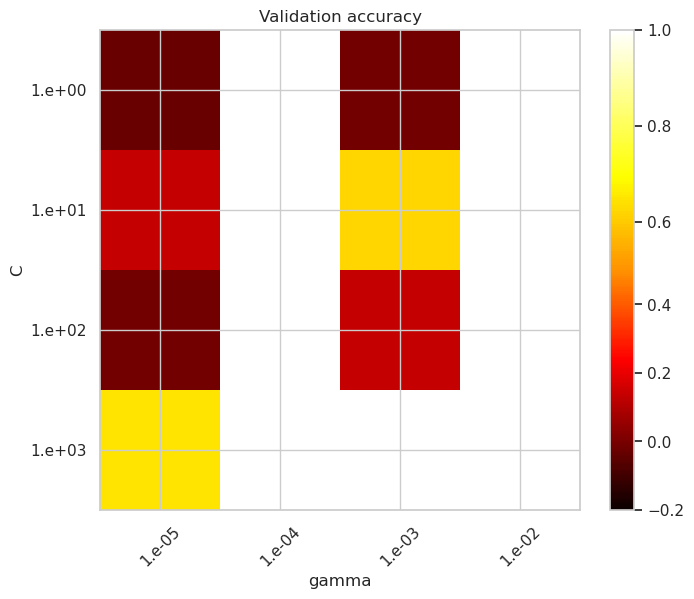

In [33]:
best_svr = clf.best_estimator_.named_steps['svr']
print('Best score for data:', clf.best_score_)
print('Best C:',best_svr.C) 
print('Best Kernel:',best_svr.kernel)
print('Best Gamma:',best_svr.gamma)

# scores for rbf kernel
n = len(gamma_range)*len(c_range)
scores_rbf = clf.cv_results_['mean_test_score'][:n].reshape(len(gamma_range),
                                                            len(c_range))

# scores for rbf kernel
scores_linear = clf.cv_results_['mean_test_score'][n:].reshape(len(gamma_range),
                                                               len(c_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rbf, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=-.2, midpoint=0.5))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)),
           [np.format_float_scientific(i,1) for i in gamma_range],rotation=45)
plt.yticks(np.arange(len(c_range)), 
           [np.format_float_scientific(i,) for i in c_range])
plt.title('Validation accuracy')
plt.savefig("Charts/SVR hypertuning.png", transparent= True)
plt.show()

In [27]:
clf

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=1,
             param_grid=[{'svr__C': [1, 10, 100, 1000],
                          'svr__gamma': [0.0001, 0.001, 0.01],
                          'svr__kernel': ['rbf', 'linear']}],
             scoring='explained_variance', verbose=20)

In [41]:
%% script false
#Alternative
params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
          'gamma': [0.0001, 0.001, 0.01, 0.1],
          'kernel':['linear','rbf'] }

#Create the GridSearchCV object
grid_clf = GridSearchCV(SVR, params_grid)

#Fit the data with the best possible parameters
grid_clf = clf.fit(X_train, y_train)

#Show the best parameters
grid_clf.best_params_

UsageError: Cell magic `%%` not found.


In [38]:
grid_clf.best_params_

{'svr__C': 10, 'svr__gamma': 1e-05, 'svr__kernel': 'linear'}

According to the Cross-Validated Grid Search, the best parameters are:
- "C": 1
- "gamma": 0.0001
- "kernel": "linear" 

In [40]:
#Hypertune parameters

svr_rbf = SVR(kernel="rbf", gamma=best_svr.gamma, C=best_svr.C).fit(X_train, y_train)       #radial basis function
svr_lin = SVR(kernel="linear", gamma=best_svr.C, C =best_svr.C).fit(X_train, y_train)              #linear function. Also LinearSVR exist.
 
predictions = svr_rbf.predict(X_test) 
print('Radial SVR root mean_squared error:',np.sqrt(mean_squared_error(y_test, predictions)))  
print('Radial SVR mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(svr_rbf.score(X_test, y_test)*100, 2), "%")

predictions = svr_lin.predict(X_test) 
print('Linear SVR root mean_squared error:',np.sqrt(mean_squared_error(y_test, predictions))) 
print('Linear SVR mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(svr_lin.score(X_test, y_test)*100, 2), "%")

Radial SVR root mean_squared error: 4.295704174205809
Radial SVR mean absolute error: 1.5792542638620422
R squared test set 98.78 %
Linear SVR root mean_squared error: 0.036299591052223405
Linear SVR mean absolute error: 0.03014364146314058
R squared test set 100.0 %


The dataset is too small!! Predictions are very imprecise.

### Decision Trees Regression

In [42]:
#Set proper m, n, trees.
reg = DecisionTreeRegressor(max_depth=2).fit(X_train, y_train)              
predictions = reg.predict(X_test) 

print('Decision Tree root mean_squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('Decision Tree mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(reg.score(X_test, y_test)*100, 2), "%")

Decision Tree root mean_squared error: 6.353077408858608
Decision Tree mean absolute error: 3.85880089775687
R squared test set 97.32 %


Good algorithm for evaluation worth keeping for the future.

### Random Forests Regressor

In [43]:
#Find best numbers!
reg = RandomForestRegressor(n_estimators=1000, max_depth=2).fit(X_train, y_train)              
predictions = reg.predict(X_test) 

print('RF Regressor root mean_squared error:', np.sqrt(mean_squared_error(y_test, predictions)))  
print('RF Regressor  mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(reg.score(X_test, y_test)*100, 2), "%")

# Displaying feature importance
feature_importance = pd.DataFrame({'Feature': X_selected.columns, 'Importance': reg.feature_importances_}) #Can be used to plot it!
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance_sorted)

RF Regressor root mean_squared error: 6.043540243560198
RF Regressor  mean absolute error: 3.7391886326805808
R squared test set 97.58 %
       Feature  Importance
5          CO2         1.0
0  Temperature         0.0
1      Voltage         0.0
2  engine_load         0.0
3         hour         0.0
4          RPM         0.0


In [44]:
fig = px.bar(
    feature_importance_sorted,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Feature Importance',
    color='Importance',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis=dict(autorange="reversed", color='white'), width=600, height=400, title_font=dict(color='white'), xaxis=dict(color='white'))  # Highest importance on top
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.show()


### GBM

In [45]:
reg = GradientBoostingRegressor(n_estimators=1000, max_depth=2).fit(X_train, y_train)              
predictions = reg.predict(X_test) 

print('GBM Regressor root mean_squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('GBM Regressor  mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(reg.score(X_test, y_test)*100, 2), "%")

# Displaying feature importance
feature_importance = pd.DataFrame({'Feature': X_selected.columns, 'Importance': reg.feature_importances_}) #Can be used to plot it!
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.sort_values(by='Importance', ascending=False))

GBM Regressor root mean_squared error: 0.28507491898620113
GBM Regressor  mean absolute error: 0.13318057461006588
R squared test set 99.99 %
       Feature    Importance
5          CO2  9.999834e-01
4          RPM  9.870595e-06
0  Temperature  3.904302e-06
3         hour  1.514145e-06
1      Voltage  1.129513e-06
2  engine_load  1.861617e-07


In [46]:
fig = px.bar(
    feature_importance_sorted,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Feature Importance',
    color='Importance',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis=dict(autorange="reversed", color='white'), width=600, height=400, title_font=dict(color='white'), xaxis=dict(color='white'))  # Highest importance on top
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.show()


Best performing so far!!!

### AdaBoost

In [47]:
#Optmize for best iteration number. Find also tolerance level associated with it!
reg = AdaBoostRegressor(n_estimators= 1000).fit(X_train, y_train)              
predictions = reg.predict(X_test) 

print('AdaBoost Regressor root mean_squared error:', np.sqrt(mean_squared_error(y_test, predictions))) 
print('AdaBoost Regressor  mean absolute error:', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(reg.score(X_test, y_test)*100, 2), "%")

# Displaying feature importance
feature_importance = pd.DataFrame({'Feature': X_selected.columns, 'Importance': reg.feature_importances_}) #Can be used to plot it!
feature_importance_sorted = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance.sort_values(by='Importance', ascending=False))

AdaBoost Regressor root mean_squared error: 2.267147171044332
AdaBoost Regressor  mean absolute error: 1.6351342364961854
R squared test set 99.66 %
       Feature  Importance
5          CO2    0.998891
3         hour    0.001109
0  Temperature    0.000000
1      Voltage    0.000000
2  engine_load    0.000000
4          RPM    0.000000


This one is also very accurate thus far.

In [48]:
fig = px.bar(
    feature_importance_sorted,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Feature Importance',
    color='Importance',
    color_continuous_scale='Viridis'
)
fig.update_layout(yaxis=dict(autorange="reversed", color='white'), width=600, height=400, title_font=dict(color='white'), xaxis=dict(color='white'))  # Highest importance on top
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.show()

### Neural Networks - Multi-layer Perceptron Regressor

In [49]:
#Optmize for best iteration number. Find also tolerance level associated with it!
reg = MLPRegressor(max_iter=2000, tol = 0.1).fit(X_train, y_train)              
predictions = reg.predict(X_test) 

print('MLP Regressor root mean_squared error: ', np.sqrt(mean_squared_error(y_test, predictions))) 
print('MLP Regressor  mean absolute error: ', mean_absolute_error(y_test, predictions)) 
print('R squared test set', round(reg.score(X_test, y_test)*100, 2), "%")

MLP Regressor root mean_squared error:  1.181658531160964
MLP Regressor  mean absolute error:  0.8694334267155948
R squared test set 99.91 %


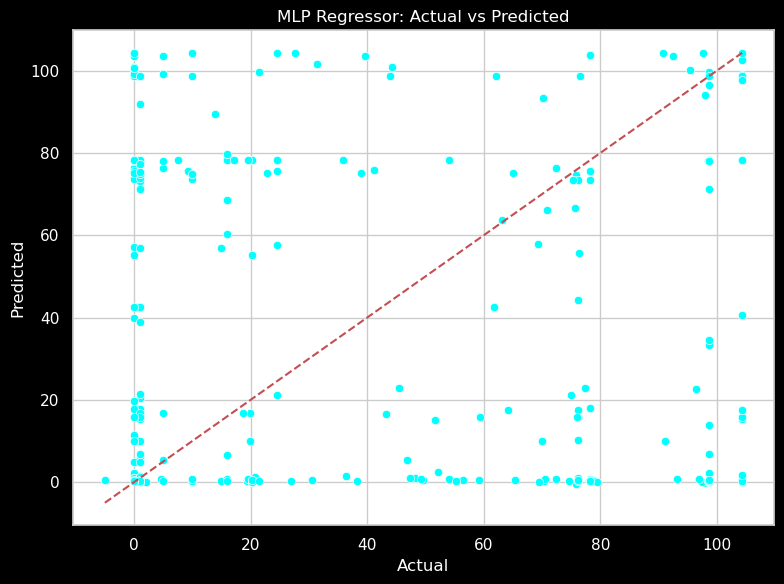

In [50]:
plt.figure(figsize=(8, 6), facecolor='black')
sns.scatterplot(x=y_test, y=y_pred, color='cyan')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual', color='white')
plt.ylabel('Predicted', color='white')
plt.title('MLP Regressor: Actual vs Predicted', color='white')
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()


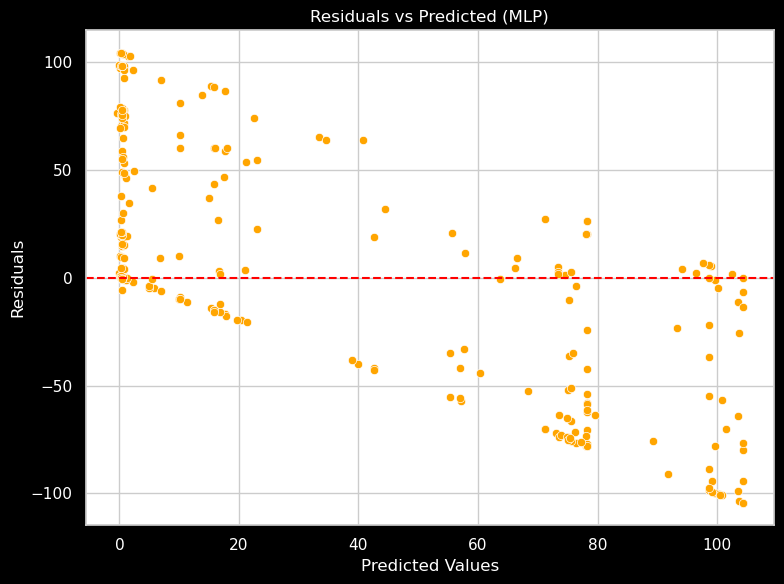

In [51]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6), facecolor='black')
sns.scatterplot(x=y_pred, y=residuals, color='orange')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Predicted Values', color='white')
plt.ylabel('Residuals', color='white')
plt.title('Residuals vs Predicted (MLP)', color='white')
plt.tick_params(colors='white')
plt.tight_layout()
plt.show()


# Visualization

In [52]:
database_electrical = database_electrical[database_electrical["device"] != "other"]
database_electrical

,time,device,sensor,CO2
0,2025-04-02 07:21:47+00:00,Outdoor Lighting #5.5,860751076088647,1.29058
1,2025-04-02 07:23:36+00:00,Box #5.5,860751070821829,1.74038
2,2025-04-02 07:29:47+00:00,Crane 1,860751070815789,9.84197
4,2025-04-02 07:31:47+00:00,Outdoor Lighting #5.5,860751076088647,1.29058
5,2025-04-02 07:31:50+00:00,Mobile Crane,860751070821241,0.13667
...,...,...,...,...
25995,2025-04-22 08:10:55+00:00,Outdoor Lighting #5.5,860751076088647,3.49806
25997,2025-04-22 08:11:56+00:00,Crane 2,860751070821126,45.54744
25999,2025-04-22 08:13:00+00:00,Crane 1,860751070815789,47.83277
26002,2025-04-22 08:15:03+00:00,Mobile Crane,860751070821241,6.52729


In [53]:
pivot_df = database_electrical.pivot(index='time', columns='device', values='CO2')
pivot_df = pivot_df.sort_index()                          # Sort by time 
pivot_df

device,Box #5.5,Crane 1,Crane 2,Mobile Crane,Outdoor Lighting #5.5
time,,,,,
2025-04-02 07:21:47+00:00,NaN,NaN,NaN,NaN,1.29058
2025-04-02 07:23:36+00:00,1.74038,NaN,NaN,NaN,NaN
2025-04-02 07:29:47+00:00,NaN,9.84197,NaN,NaN,NaN
2025-04-02 07:31:47+00:00,NaN,NaN,NaN,NaN,1.29058
2025-04-02 07:31:50+00:00,NaN,NaN,NaN,0.13667,NaN
...,...,...,...,...,...
2025-04-22 08:10:55+00:00,NaN,NaN,NaN,NaN,3.49806
2025-04-22 08:11:56+00:00,NaN,NaN,45.54744,NaN,NaN
2025-04-22 08:13:00+00:00,NaN,47.83277,NaN,NaN,NaN


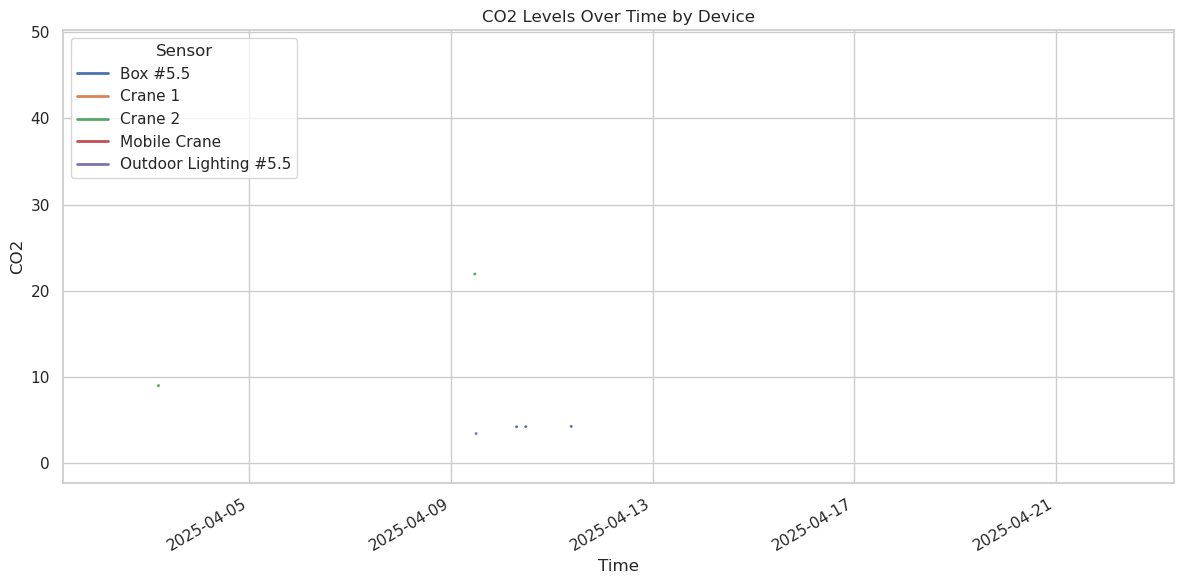

In [54]:
# Plot
pivot_df.plot(figsize=(12, 6), linewidth=2)
plt.title("CO2 Levels Over Time by Device")
plt.xlabel("Time")
plt.ylabel("CO2")
#plt.ylim("2025-04-03 08:00:00", "2025-04-03 16:00:00")
plt.legend(title="Sensor")
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
database_fuel

,machine,timestamp,Temperature,Voltage,distance,engine_hours,engine_load,fuel_consumption,fuel_count,lat,lon,CODE,status,hour,source,RPM,idle_threshold,CO2
0,13013-MerloP40.17,2025-03-24 06:10:00,40.0,11578.0,0.000000,0.00,0.0,0.0,22569.000000,55.720610,9.128192,13013,down,6.0,fuel,1317.577612,872.835821,0.0000
1,13013-MerloP40.17,2025-03-24 06:12:00,210.0,13091.0,58.000000,2.00,66.0,1.0,22570.000000,55.720898,9.128118,13013,working,6.0,fuel,1317.577612,872.835821,2.6670
2,13013-MerloP40.17,2025-03-24 06:13:00,370.0,13139.0,90.000000,1.00,29.0,1.0,22571.000000,55.721737,9.128656,13013,working,6.0,fuel,1317.577612,872.835821,2.6670
3,13013-MerloP40.17,2025-03-24 06:14:00,460.0,13144.0,0.000000,1.00,16.0,1.0,22572.000000,55.721767,9.128919,13013,working,6.0,fuel,1317.577612,872.835821,2.6670
4,13013-MerloP40.17,2025-03-24 06:15:00,520.0,13062.0,0.000000,1.00,80.0,0.0,22572.000000,55.721767,9.128919,13013,working,6.0,fuel,1317.577612,872.835821,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5355,Caterpillar_938M,13-02-2025 14:45,71.0,27400.0,89.633779,2.33,0.0,24.5,22996.264214,55.721134,9.127781,938M,working,14.0,fuel,1566.000000,850.000000,65.3415
5356,Caterpillar_938M,13-02-2025 14:46,69.0,27400.0,89.633779,2.33,0.0,24.5,22996.264214,55.721134,9.127781,938M,working,14.0,fuel,1219.000000,850.000000,65.3415
5357,Caterpillar_938M,13-02-2025 14:47,68.0,25600.0,89.633779,2.33,0.0,24.5,22996.264214,55.721134,9.127781,938M,down,14.0,fuel,0.000000,850.000000,65.3415
5358,Caterpillar_938M,13-02-2025 14:48,68.0,27400.0,89.633779,2.33,0.0,24.5,22996.264214,55.721134,9.127781,938M,working,14.0,fuel,1228.000000,850.000000,65.3415


In [56]:
# Plot
fig = px.line(database_fuel, x='timestamp', y='CO2', color='machine',
              title='CO2 Levels Over Time by Machine', 
              labels={'CO2': 'CO2 Level', 'timestamp': 'Timestamp', 'machine': 'Machines'},  width=600, height=400)
fig.update_layout(xaxis_title='Time', yaxis_title='CO2', legend_title='Heavy Machinery',
                  xaxis_range=["2025-03-24", "2025-04-02"])
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
fig.show()
pio.write_image(fig, 'CO2_fuel_presentation.svg')

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [ ]:
mask = (database_fuel["timestamp"] >= "2025-02-02")
mask

TypeError: '>=' not supported between instances of 'Timestamp' and 'str'

In [ ]:
# Plot
fig = px.line(database_fuel, x='timestamp', y='CO2', color='CODE',
              title='CO2 Levels Over Time by Machine (Phase 2)', 
              labels={'CO2': 'CO2 Level', 'timestamp': 'Timestamp', 'CODE': 'Machines'},  width=600, height=400)
fig.update_layout(xaxis_title='Time', yaxis_title='CO2', legend_title='Heavy Machinery',
                  xaxis_range=["2025-04-04", "2025-04-10"])
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
keys = list(locals().keys())
for l in keys:
    if l[:3] == 'fig':
        locals()[l].update_layout(font_color = 'white', font_size = 15)
plt.savefig("Charts/CO2_fuel_presentation.png")
fig.show()
#pio.write_image(fig, 'CO2_fuel_presentation.svg')

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = px.line(database_electrical, x='time', y='CO2', color='device',
              title='CO2 Levels Over Time by Device',
              labels={'CO2': 'CO2 Level', 'time': 'Timestamp', 'device': 'Device'},  width=600, height=400)
fig.update_layout(xaxis_title='Time', yaxis_title='CO2', legend_title='Devices')
fig.update_layout({'plot_bgcolor': 'rgba(0,0,0,0)', 'paper_bgcolor': 'rgba(0,0,0,0)'})
keys = list(locals().keys())
for l in keys:
    if l[:3] == 'fig':
        locals()[l].update_layout(font_color = 'white', font_size = 15)
plt.savefig("Charts/CO2_electricity_presentation.png")
fig.show()
#pio.write_image(fig, 'CO2_electrical_presentation.svg')

/usr/lib/python3/dist-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



<Figure size 640x480 with 0 Axes>